# TFG. Detección de anomalías en contaminación del aire. 
#### Lucía Carro Arcaya

## Pasos previos

### Carga de librerías

In [1]:
import os
import json
import math
import folium
import calendar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Cargamos los datos.

In [2]:
datos22 = pd.read_json("datos/Aire.BSG.A01-A11.2022.json")
datos23 = pd.read_json("datos/Aire.BSG.A01-A11.2023.json")
datos24 = pd.read_json("datos/Aire.BSG.A01-A11.2024.Parcial.json")

Al cargar los datos, vamos a confirmar que todas las columnas sean las mismas. Si no es así vemos en cuáles difieren. 

In [3]:
cols22 = set(datos22.columns)
cols23 = set(datos23.columns)
cols24 = set(datos24.columns)

comunes = cols22 & cols23 & cols24
union_cols = cols22 | cols23 | cols24
diff_cols = union_cols - comunes

print("Las columnas que difieren entre los tres datasets son: ", diff_cols)

Las columnas que difieren entre los tres datasets son:  {'project'}


Como no es una columna relevante para nuestro análisis la eliminamos.

In [4]:
datos23 = datos23.drop(columns=["project"])
datos24 = datos24.drop(columns=["project"])

Vemos las dimensiones de los datos y como están estructurados dentro del archivo .json.

Como las columnas son comunes a los 3, vamos a unirlos en uno solo para facilitar el estudio posterior.

In [5]:
# Miramos las dimensiones de datos22
print("Dimensión 2022 :", datos22.shape)
print("Dimensión 2023 :", datos23.shape)
print("Dimensión 2024 :", datos24.shape)
print("-"*50)

columnas_comunes = sorted(set(datos22.columns) & set(datos23.columns) & set(datos24.columns))
datos22 = datos22[columnas_comunes]
datos23 = datos23[columnas_comunes]
datos24 = datos24[columnas_comunes]

# Combinamos los datasets (uno tras otro)
datos_total = pd.concat([datos22, datos23, datos24], ignore_index=True)
print(f"Total registros combinados: {len(datos_total)}")

# Y vemos la lista de columnas
for col in sorted(datos_total.columns):
    print(col)

Dimensión 2022 : (546526, 63)
Dimensión 2023 : (568072, 63)
Dimensión 2024 : (223665, 63)
--------------------------------------------------
Total registros combinados: 1338263
NO2Description
NO2Name
NO2Type
NO2Value
NO2ValueFlag
NO2ValueOrigin
NODescription
NOName
NOType
NOValue
NOValueFlag
NOValueOrigin
NOXDescription
NOXName
NOXType
NOXValue
NOXValueFlag
NOXValueOrigin
O3Description
O3Name
O3Type
O3Value
O3ValueFlag
O3ValueOrigin
PM10CorrectionFactor
PM10Description
PM10Name
PM10Type
PM10Value
PM10ValueFlag
PM10ValueFull
PM10ValueOrigin
PM1Description
PM1Name
PM1Type
PM1Value
PM1ValueFlag
PM1ValueOrigin
PM25Description
PM25Name
PM25Type
PM25Value
PM25ValueFlag
PM25ValueOrigin
SO2Description
SO2Name
SO2Type
SO2Value
SO2ValueFlag
SO2ValueOrigin
_id
dateObserved
dateObservedGMT0
entityId
entityType
location
maintenanceOwner
maintenanceOwnerEmail
operationalStatus
recvTime
refPointOfInterest
serviceOwner
serviceOwnerEmail


Vemos como está estructurado el archivo .json

In [6]:
# Convertimos la fila a un diccionario y transformamos valores no serializables
fila = datos22.iloc[0].copy()
fila = fila.where(pd.notna(fila), None).to_dict()

# Convertimos timestamps a strings
for key, value in fila.items():
    if isinstance(value, pd.Timestamp):
        fila[key] = value.isoformat()  # Formato 'YYYY-MM-DDTHH:MM:SS'

# Serializamos a JSON e imprimir
print(json.dumps(fila, indent=4, ensure_ascii=False))

{
    "NO2Description": "Dióxido de Nitrogeno",
    "NO2Name": "NO2",
    "NO2Type": "µg/m3",
    "NO2Value": 27,
    "NO2ValueFlag": "V",
    "NO2ValueOrigin": 27.0,
    "NODescription": null,
    "NOName": null,
    "NOType": null,
    "NOValue": null,
    "NOValueFlag": null,
    "NOValueOrigin": null,
    "NOXDescription": null,
    "NOXName": null,
    "NOXType": null,
    "NOXValue": null,
    "NOXValueFlag": null,
    "NOXValueOrigin": null,
    "O3Description": "Ozono",
    "O3Name": "O3",
    "O3Type": "µg/m3",
    "O3Value": 14.0,
    "O3ValueFlag": "V",
    "O3ValueOrigin": 14.0,
    "PM10CorrectionFactor": 1.0,
    "PM10Description": "Particulas en suspensión inferiores a 10 micras",
    "PM10Name": "PM10",
    "PM10Type": "µg/m3",
    "PM10Value": 61.0,
    "PM10ValueFlag": "V",
    "PM10ValueFull": 61.0,
    "PM10ValueOrigin": 61.0,
    "PM1Description": null,
    "PM1Name": null,
    "PM1Type": null,
    "PM1Value": null,
    "PM1ValueFlag": null,
    "PM1ValueOrigin": n

Vemos en que estaciones se recogen datos, esto es en la columna entityId y donde están ubicadas.

Las estaciones son las mismas para los 3 años de datos. 

In [7]:
mapa = datos_total.copy()

# Extraemos las coordenadas
mapa["coords"] = mapa["location"].apply(lambda x: x["coordinates"] if isinstance(x, dict) else None)
mapa[["longitud", "latitud"]] = pd.DataFrame(mapa["coords"].tolist(), index=mapa.index)

# Quitamos las coordenadas duplicadas
coordenadas = mapa[["latitud", "longitud", "entityId"]].drop_duplicates()

# Creamos el mapa centrado en Valencia
mapa_est = folium.Map(location=[39.4699, -0.3763], zoom_start=13)

# Agregamos marcadores en cada ubicación donde se encuentra una estación
for _, row in coordenadas.iterrows():
    estacion = row["entityId"] if "entityId" in row else "Estación desconocida"

    folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=f"{estacion}<br>Lat: {row['latitud']}, Lng: {row['longitud']}",
        tooltip=estacion
    ).add_to(mapa_est)

# Guardamos y mostramos el mapa
mapa_est.save("mapa_estaciones.html")
mapa_est

## Preprocesado de datos

Conevrtimos los datos a dataframe. 

In [8]:
datos_total = pd.DataFrame(datos_total)
datos_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338263 entries, 0 to 1338262
Data columns (total 63 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   NO2Description         1333407 non-null  object 
 1   NO2Name                1333407 non-null  object 
 2   NO2Type                1333407 non-null  object 
 3   NO2Value               1333407 non-null  float64
 4   NO2ValueFlag           1333407 non-null  object 
 5   NO2ValueOrigin         1333407 non-null  float64
 6   NODescription          300792 non-null   object 
 7   NOName                 300792 non-null   object 
 8   NOType                 300792 non-null   object 
 9   NOValue                300792 non-null   float64
 10  NOValueFlag            300792 non-null   object 
 11  NOValueOrigin          300792 non-null   float64
 12  NOXDescription         300792 non-null   object 
 13  NOXName                300792 non-null   object 
 14  NOXType           

### 1. Convertir columnas de fecha

In [9]:
# Extraemos la cadena de fecha si el valor es un diccionario con la clave "$date"
def extract_date(value):
    if isinstance(value, dict) and "$date" in value:
        return value["$date"]
    return value

# Lista de columnas de fecha a procesar
date_columns = ["dateObserved", "dateObservedGMT0", "recvTime"]

# Extraemos y convertimos a datetime para cada columna de fecha
for col in date_columns:
    datos_total[col] = datos_total[col].apply(extract_date)
    datos_total[col] = pd.to_datetime(datos_total[col], errors="coerce")

# Verificamos
print(datos_total[date_columns].head(1))
print(datos_total[date_columns].info())

               dateObserved          dateObservedGMT0  \
0 2022-01-01 00:00:00+00:00 2021-12-31 23:00:00+00:00   

                          recvTime  
0 2021-12-31 23:15:14.419000+00:00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338263 entries, 0 to 1338262
Data columns (total 3 columns):
 #   Column            Non-Null Count    Dtype              
---  ------            --------------    -----              
 0   dateObserved      1338263 non-null  datetime64[ns, UTC]
 1   dateObservedGMT0  1338263 non-null  datetime64[ns, UTC]
 2   recvTime          1338263 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3)
memory usage: 30.6 MB
None


### 2. Convertir columnas a numérico

In [10]:
col_num = [col for col in datos_total.columns 
           if col.endswith("Value") or col.endswith('ValueOrigin')]

for col in col_num:
    datos_total[col] = datos_total[col].astype('float64')

### 3. Eliminar columnas irrelevantes (lista ajustable)

El total de datos sabemos que es 546526, hay columnas que solo tenemos NaN y otro valor en el resto de obsevaciones, no es necesario quedarnos con esas columnas

In [11]:
# Lista de columnas con muchos NaN o de poco interés
cols_organizacion = [
    "_id", "operationalStatus", "maintenanceOwner", "serviceOwner", 
    "maintenanceOwnerEmail", "serviceOwnerEmail", "refPointOfInterest",
    "entityType", "recvTime", "dateObservedGMT0"]

# Lista de columnas con valores de contaminantes y partículas poco relevantes
cols_contam =  ["NO2Description", "NO2Name", "NO2Type", "NO2ValueFlag",
                "NODescription", "NOName", "NOType", "NOValueFlag",
                "NOXDescription", "NOXName", "NOXType", "NOXValueFlag",
                "O3Description", "O3Name", "O3Type", "O3ValueFlag",
                "SO2Description", "SO2Name", "SO2Type", "SO2ValueFlag"]

cols_part = ["PM10Description", "PM10Name", "PM10Type", "PM10ValueFlag",
             "PM1Description", "PM1Name", "PM1Type", "PM1ValueFlag",
             "PM25Description", "PM25Name", "PM25Type", "PM25ValueFlag"]

datos_total = datos_total.drop(columns=cols_organizacion + cols_contam + cols_part)

# Verificamos las nuevas dimensiones
print(f"Dimensiones después de eliminar columnas irrelevantes: {datos_total.shape}")
datos_total.head(1)

Dimensiones después de eliminar columnas irrelevantes: (1338263, 21)


,NO2Value,NO2ValueOrigin,NOValue,NOValueOrigin,NOXValue,NOXValueOrigin,O3Value,O3ValueOrigin,PM10CorrectionFactor,PM10Value,...,PM10ValueOrigin,PM1Value,PM1ValueOrigin,PM25Value,PM25ValueOrigin,SO2Value,SO2ValueOrigin,dateObserved,entityId,location
0,27.0,27.0,NaN,NaN,NaN,NaN,14.0,14.0,1.0,61.0,...,61.0,NaN,NaN,42.0,42.2,2.0,2.1,2022-01-01 00:00:00+00:00,A01_AVFRANCIA_10m,"{'coordinates': [-0.34266019999999997, 39.4575..."


### 4. Eliminar duplicados por dateObserved y entityId

In [12]:
print(f"Registros antes de eliminar duplicados: {datos_total.shape[0]}")

# Eliminamos duplicados por fecha y estación
datos_total = datos_total.drop_duplicates(subset=["dateObserved", "entityId"], 
                                          keep='first')

print(f"Registros después de eliminar duplicados: {datos_total.shape[0]}")

Registros antes de eliminar duplicados: 1338263
Registros después de eliminar duplicados: 1338092


### 5. Seleccionamos dateObserved como índice para tratarlo como ST


In [13]:
datos_total = datos_total.sort_values("dateObserved")
# Modificamos el índice para que sea la fecha de observación en un df distinto
datos_index = datos_total.copy()
datos_index.set_index("dateObserved", inplace=True)
#print(datos_index.head(1))
#print(datos_index.tail(1))

### 6. Agregar los datos

En este caso vamos a realizar un agregado global:

- 'datos_d_global': medias diarias considerando todas las estaciones juntas.
- 'datos_h_global': medias horarias considerando todas las estaciones juntas. 

Y por otro lado un agregado por estación de medición: 
- 'datos_d_estacion': medias diarias separadas por estación de medición.
- 'datos_h_estacion': medias horarias separadas por estación de medición. 

In [14]:
# Realizamos una copia inicial con el índice de fecha
datos_copia = datos_index.copy()

# AGREGADO GLOBAL DE LOS DATOS(solo con los datos numéricos)
# Quitamos la columna de localización
datos_copia.drop(columns=["location"], inplace=True)

# Agregado diario de los datos
datos_d_global = datos_copia[col_num].resample("D").mean()
# Agregado horario de los datos
datos_h_global = datos_copia[col_num].resample("H").mean()

# Vemos las dimensiones de los datos agregados
print(f"Datos agregados diarios: {datos_d_global.shape}")
print(f"Datos agregados horarios: {datos_h_global.shape}")

Datos agregados diarios: (879, 16)
Datos agregados horarios: (21086, 16)


In [15]:
# Realizamos una copia inicial sin el índice de fecha
datos_copia2 = datos_total.copy()

# AGREGADO POR ESTACIONES DE MEDIDA 
# Extraer latitud y longitud desde la columna 'location'
datos_copia2["lon"] = datos_copia2["location"].apply(lambda x: x["coordinates"][0] if isinstance(x, dict) else None)
datos_copia2["lat"] = datos_copia2["location"].apply(lambda x: x["coordinates"][1] if isinstance(x, dict) else None)

# Extraer ubicación única por estación
localizaciones = datos_copia2[["entityId", "lat", "lon"]].drop_duplicates(subset="entityId")

# Quitamos la columna de localización
datos_copia2.drop(columns=["location"], inplace=True)

# Agregado diario de los datos por estación
datos_d_estacion = datos_copia2.groupby("entityId").resample("D", on='dateObserved').mean().reset_index()
# Agregado horario de los datos por estación
datos_h_estacion = datos_copia2.groupby("entityId").resample("H", on='dateObserved').mean().reset_index()

# Vemos las dimensiones de los datos agregados por estación
print(f"Datos agregados diarios por estación: {datos_d_estacion.shape}")
print(f"Datos agregados horarios por estación: {datos_h_estacion.shape}")

Datos agregados diarios por estación: (9549, 22)
Datos agregados horarios por estación: (229038, 22)


Vemos ahora cuantos días y horas exactos tiene cada estación.

In [16]:
conteo_dias_est = datos_d_estacion.groupby("entityId")["dateObserved"].count()
print(f"Número de días registrados por estación: {conteo_dias_est}", "\n", "-"*50)

conteo_horas_est = datos_h_estacion.groupby("entityId")["dateObserved"].count()
print(f"Número de horas registradas por estación: {conteo_horas_est}")

Número de días registrados por estación: entityId
A01_AVFRANCIA_10m         879
A02_BULEVARDSUD_10m       879
A03_MOLISOL_10m           879
A04_PISTASILLA_10m        879
A05_POLITECNIC_10m        879
A06_VIVERS_10m            879
A07_VALENCIACENTRE_10m    879
A08_DR_LLUCH_10m          879
A09_CABANYAL_10m          879
A10_OLIVERETA_10m         840
A11_PATRAIX_10m           798
Name: dateObserved, dtype: int64 
 --------------------------------------------------
Número de horas registradas por estación: entityId
A01_AVFRANCIA_10m         21086
A02_BULEVARDSUD_10m       21075
A03_MOLISOL_10m           21086
A04_PISTASILLA_10m        21086
A05_POLITECNIC_10m        21086
A06_VIVERS_10m            21086
A07_VALENCIACENTRE_10m    21086
A08_DR_LLUCH_10m          21086
A09_CABANYAL_10m          21086
A10_OLIVERETA_10m         20150
A11_PATRAIX_10m           19125
Name: dateObserved, dtype: int64


### 7. Visualizar los datos

#### 7.1. Gráficos globales

Vemos primero los datos agregados sin separar por estación (todos los contaminantes y partículas). 

CONTAMINANTES


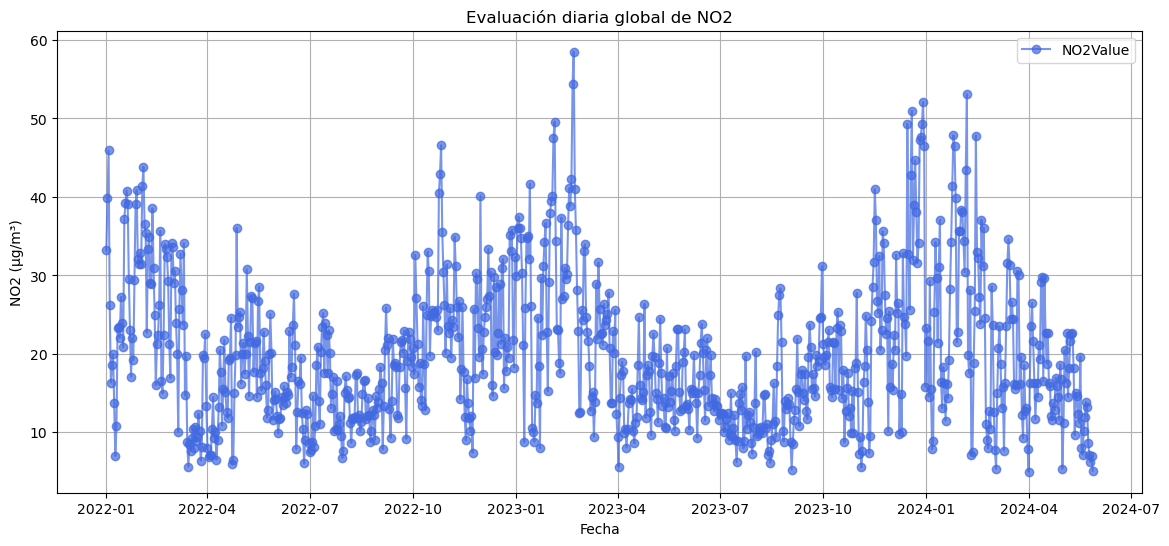

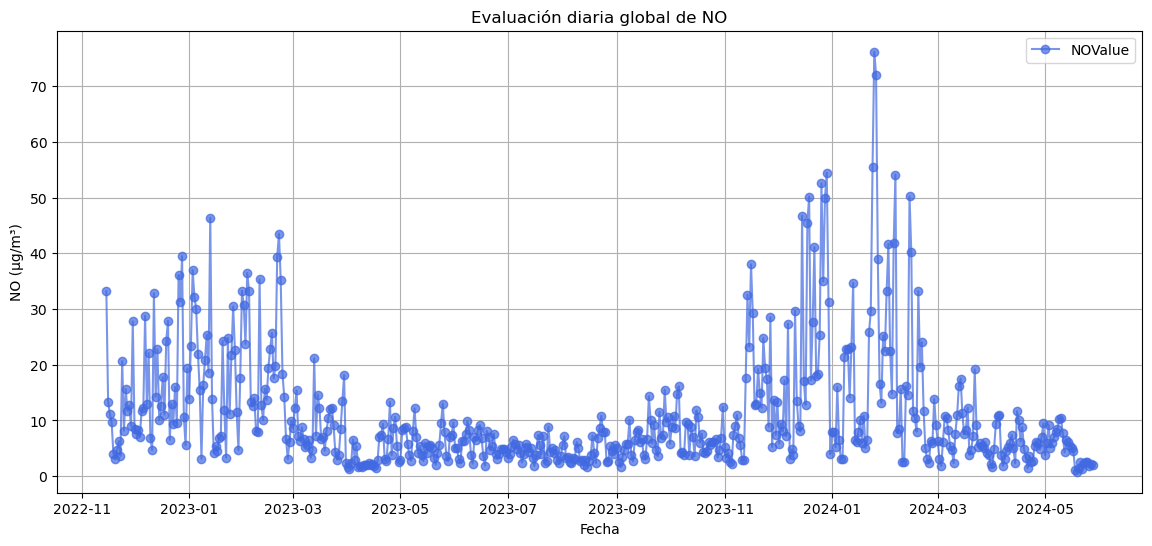

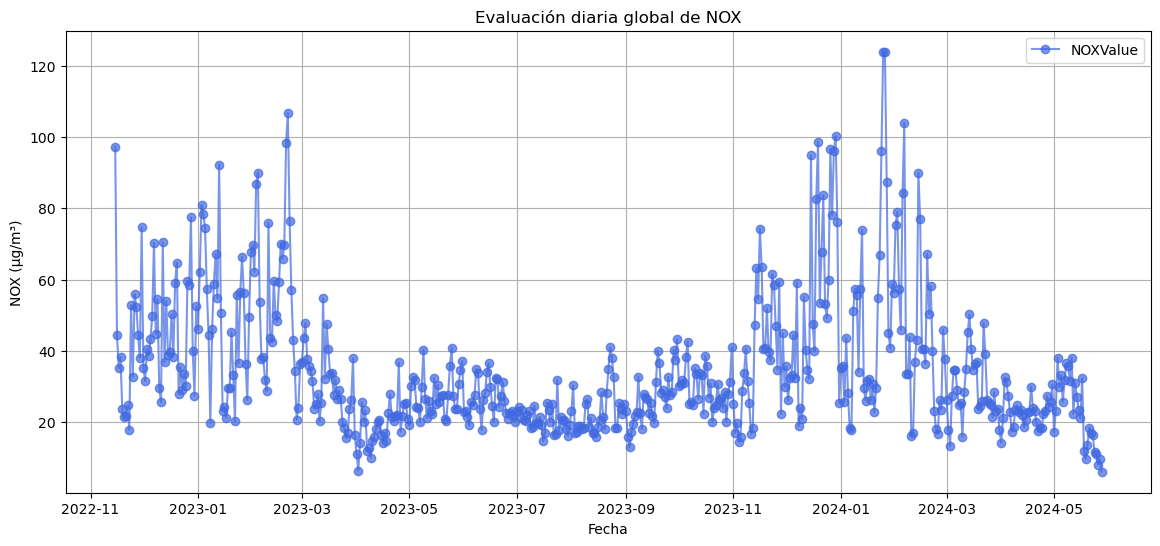

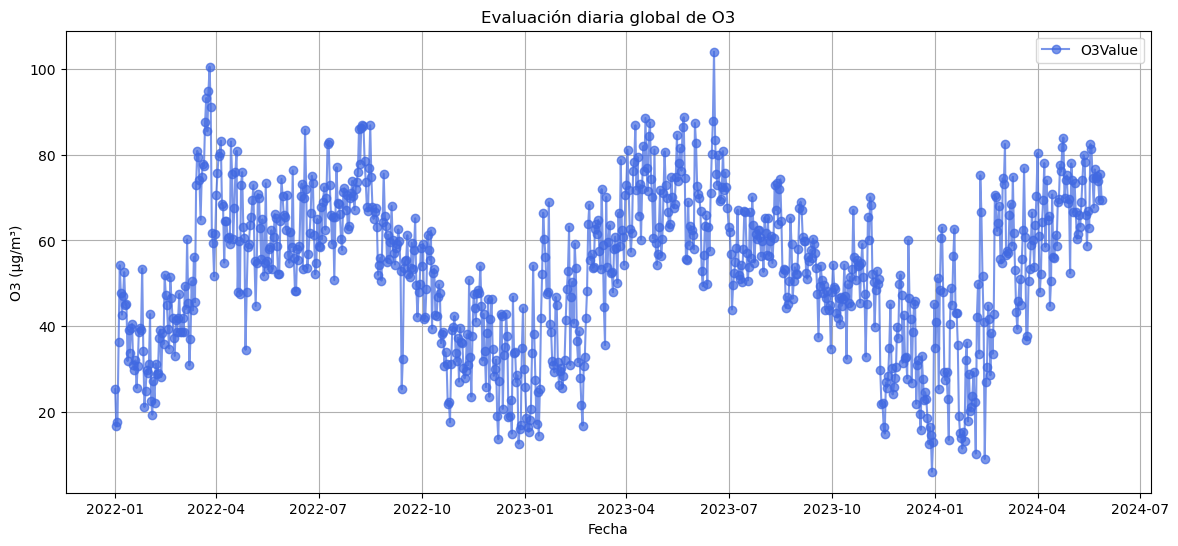

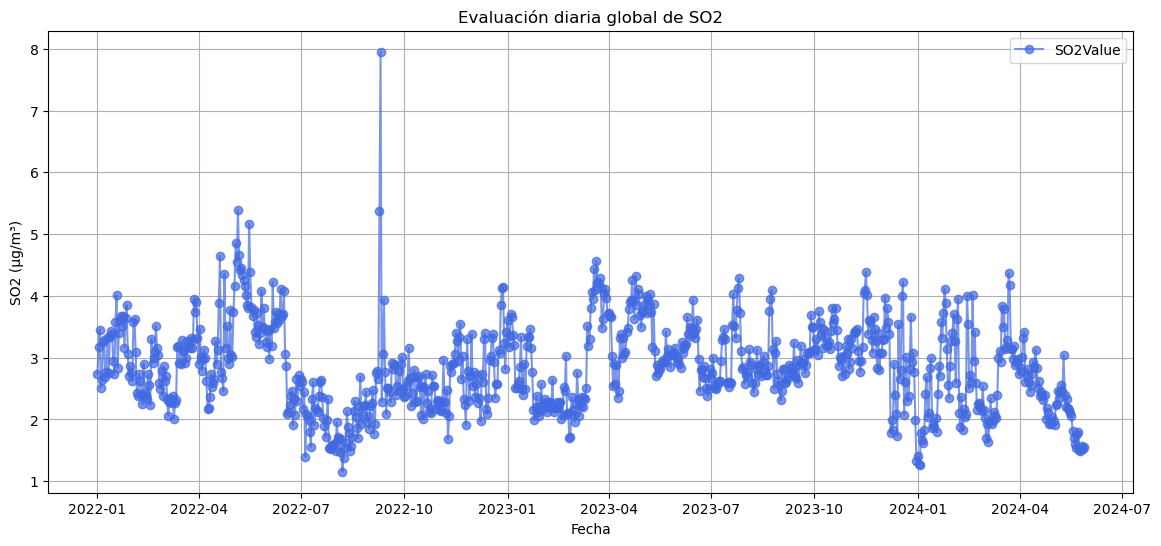

--------------------------------------------------
PARTÍCULAS


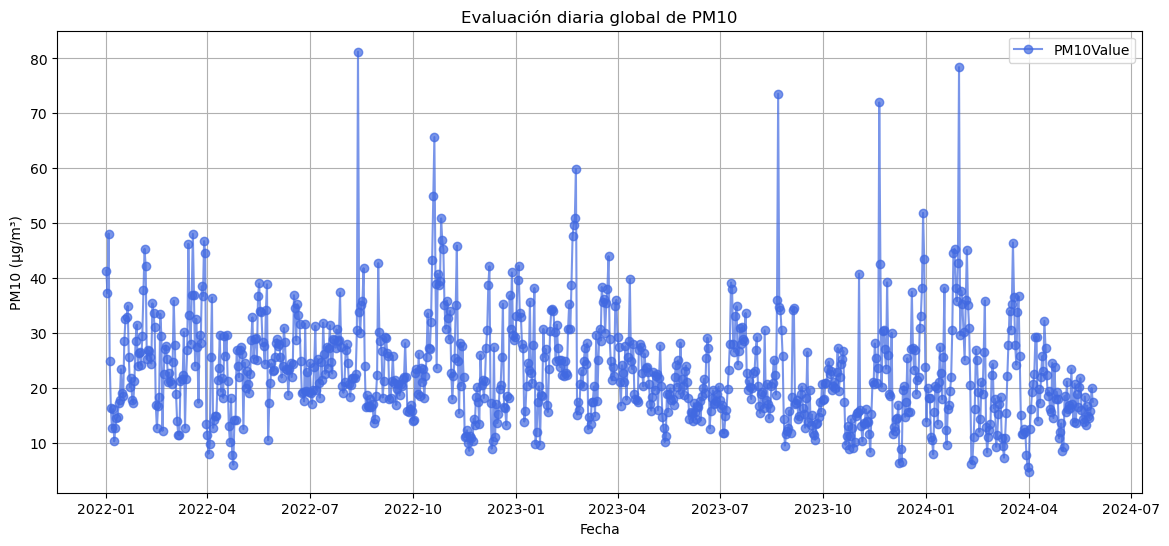

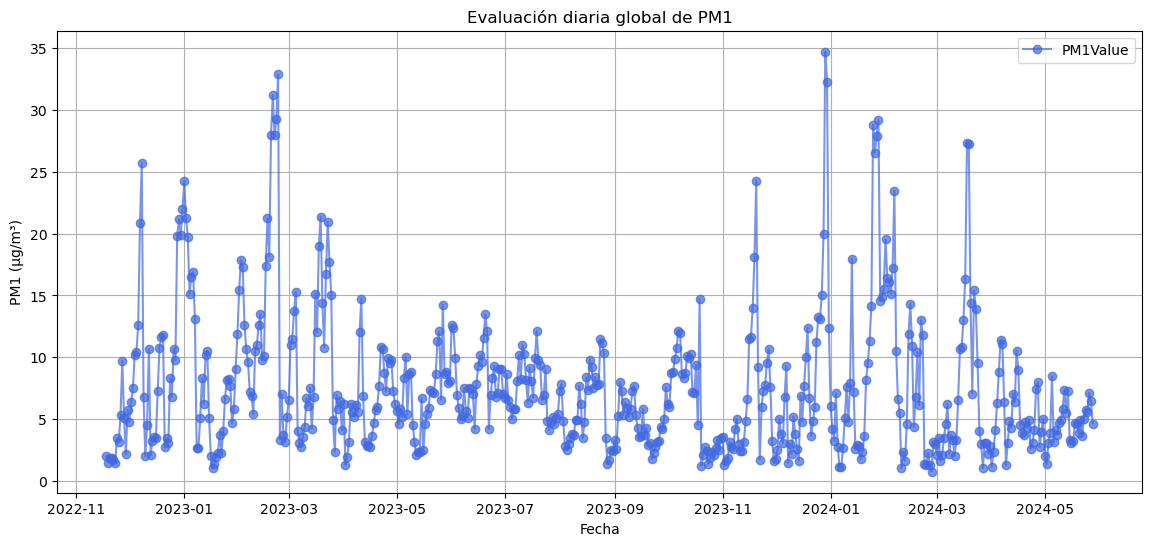

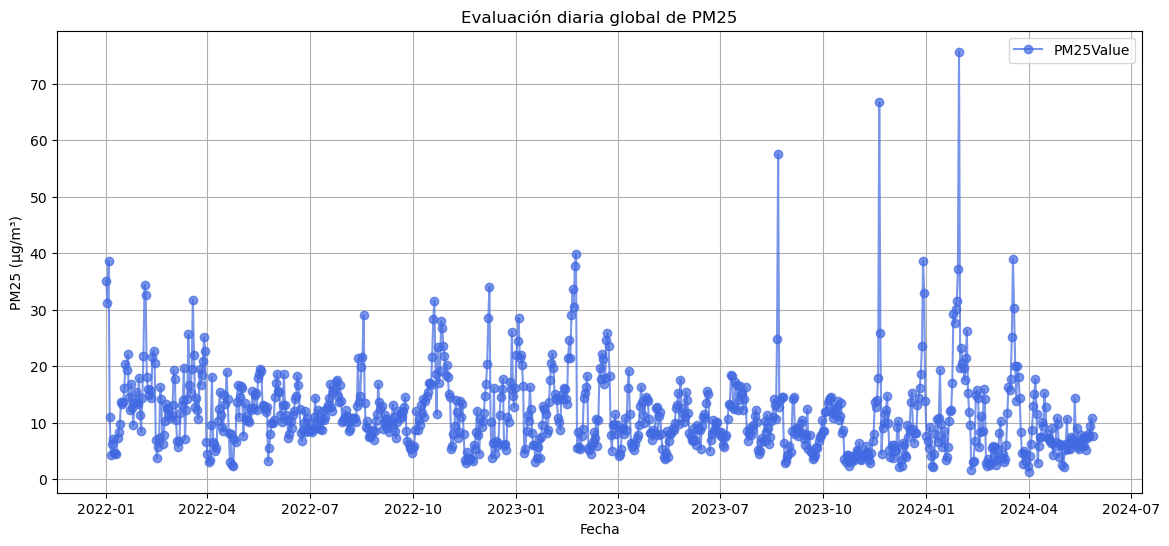

In [17]:
print("CONTAMINANTES")
contaminantes = ['NO2', 'NO', 'NOX', 'O3', 'SO2']

for c in contaminantes:
    value_col = c + 'Value'

    if value_col in datos_d_estacion.columns:
        plt.figure(figsize=(14, 6))
        plt.plot(datos_d_global.index, datos_d_global[value_col], label=f"{value_col}", color='royalblue', linestyle='-', marker='o', alpha=0.7)
        plt.title(f"Evaluación diaria global de {c}")
        plt.xlabel("Fecha")
        plt.ylabel(f"{c} (µg/m³)")
        plt.legend()
        plt.grid()
        plt.show()
print("-"*50)
print("PARTÍCULAS")
particulas = ["PM10", "PM1", "PM25"]

for c in particulas:
    value_col = c + 'Value'

    if value_col in datos_d_estacion.columns:
        plt.figure(figsize=(14, 6))
        plt.plot(datos_d_global.index, datos_d_global[value_col], label=f"{value_col}", color='royalblue', linestyle='-', marker='o', alpha=0.7)
        plt.title(f"Evaluación diaria global de {c}")
        plt.xlabel("Fecha")
        plt.ylabel(f"{c} (µg/m³)")
        plt.legend()
        plt.grid()
        plt.show()

#### 7.2. Gráficos por estación

Vemos ahora algunos de los gráficos por estación, seleccionamos las siguientes estaciones:
- A07_VALENCIACENTRE_10m: Centro urbano real, máximo tráfico, núcleo histórico.
- A09_CABANYAL_10m: Zona costera, con influencia marina.
- A11_PATRAIX_10m: Zona suburbana/periférica, además vimos que tiene más huecos(comprobar).

Y los siguientes contaminantes:
- NO2: Relacionado con tráfico urbano, calefacciones.
- PM10: Polvo, tráfico, obras.
- PM25:Partículas ultrafinas, peligrosas para salud.

Pero podemos modificar esto en cualquier momento. 

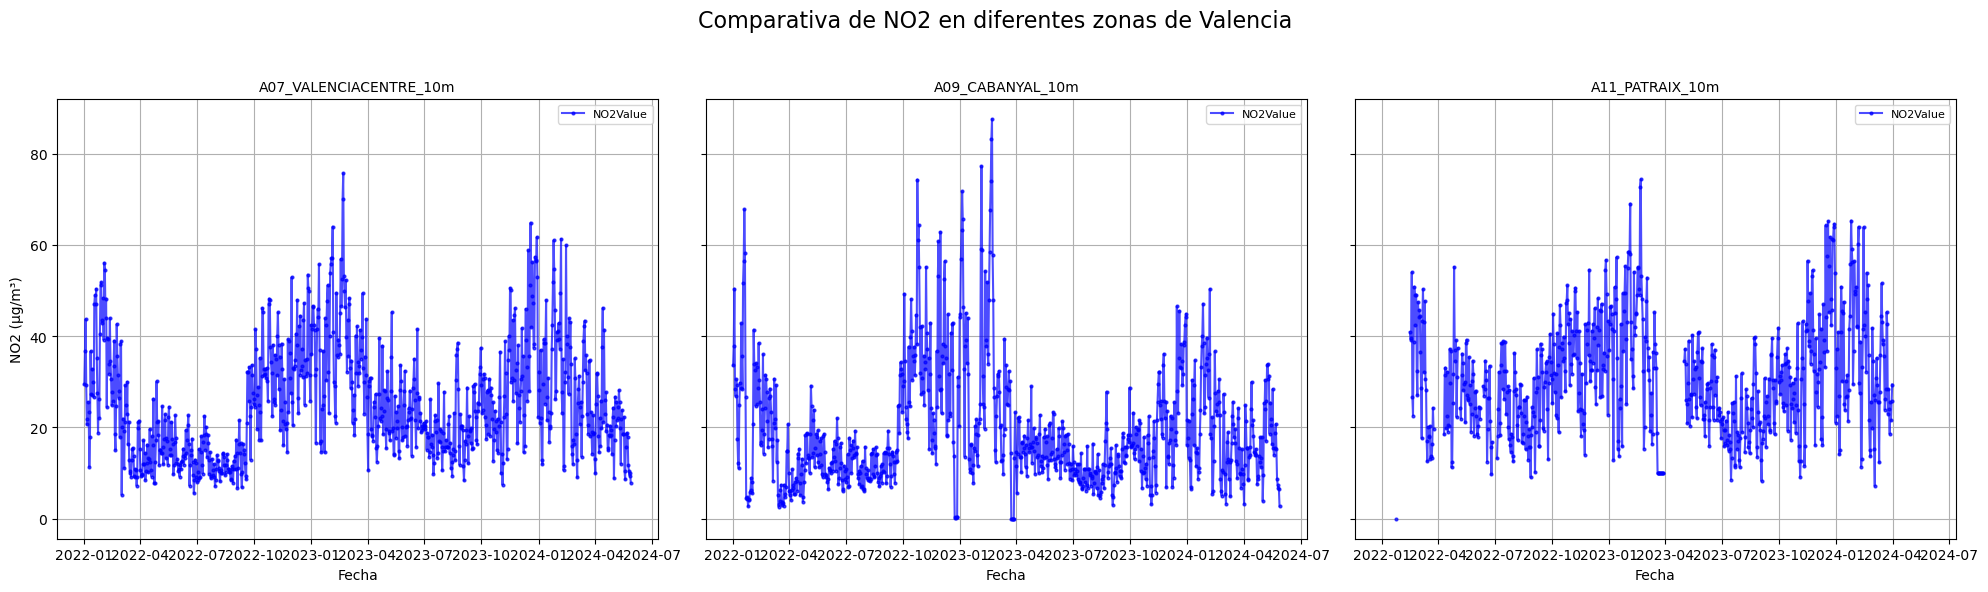

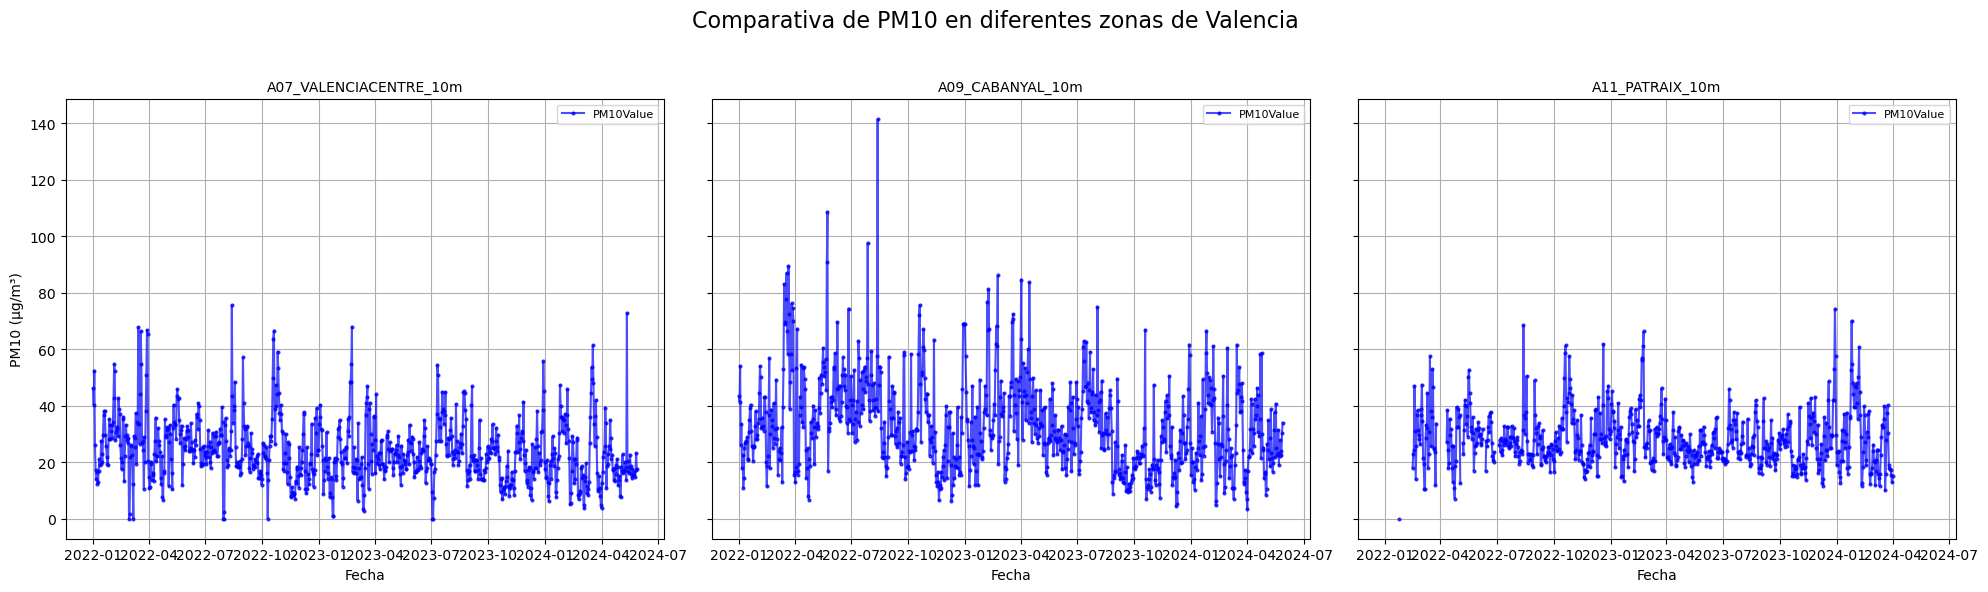

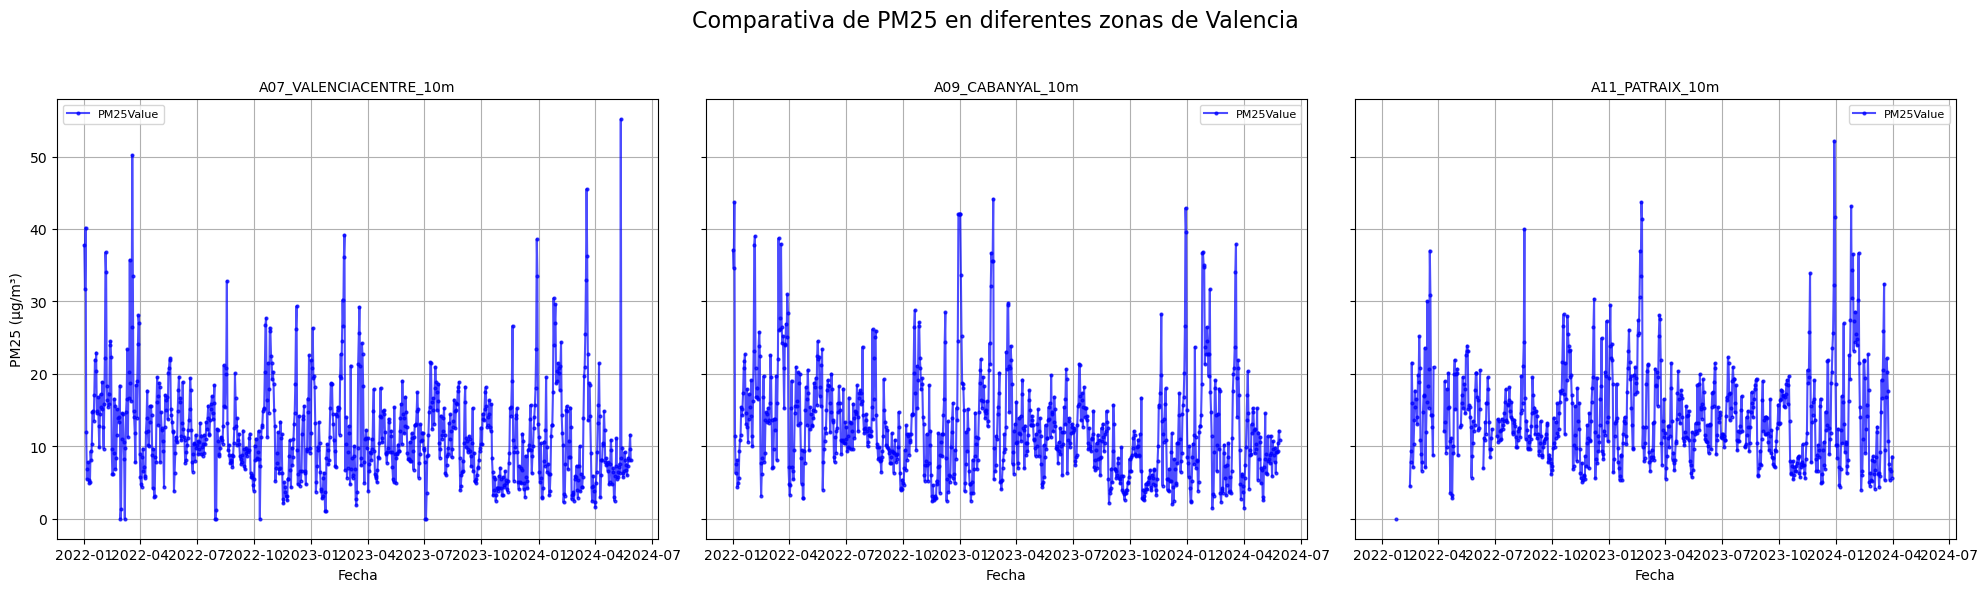

In [18]:
estaciones = ['A07_VALENCIACENTRE_10m', 'A09_CABANYAL_10m', 'A11_PATRAIX_10m']
contaminantes = ['NO2', 'PM10', 'PM25']

for contaminante in contaminantes:
    value_col = contaminante + 'Value'
    
    fig, axes = plt.subplots(1, 3, figsize=(20,6), sharex=True, sharey=True)
    
    for idx, estacion in enumerate(estaciones):
        datos_estacion = datos_d_estacion[datos_d_estacion['entityId'] == estacion]
        
        axes[idx].plot(datos_estacion['dateObserved'], datos_estacion[value_col], label=f'{value_col}', color='blue', linestyle='-', marker='o', markersize=2, alpha=0.7)
        axes[idx].set_title(estacion, fontsize=10)
        axes[idx].grid(True)
        axes[idx].legend(fontsize=8)
        axes[idx].set_xlabel('Fecha')
        if idx == 0:
            axes[idx].set_ylabel(f'{contaminante} (µg/m³)')

    plt.suptitle(f'Comparativa de {contaminante} en diferentes zonas de Valencia', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### 8. Guardamos los datos con el preprocesado realizado para utilizarlos posteriormente

In [19]:
datos_d_global.to_csv("datos_procesados/datos_d_global.csv", index=True)
datos_h_global.to_csv("datos_procesados/datos_h_global.csv", index=True)
datos_d_estacion.to_csv("datos_procesados/datos_d_estacion.csv", index=True)
datos_h_estacion.to_csv("datos_procesados/datos_h_estacion.csv", index=True)
datos_index.to_csv("datos_procesados/datos_index.csv", index=True)
localizaciones.to_csv("datos_procesados/localizaciones.csv", index=True)

print("Datos procesados guardados correctamente.")

Datos procesados guardados correctamente.
